In [2]:
import torchvision.models as models
import os
from PIL import Image
import numpy as np
import collections
import time

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision import transforms
import io
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model, ModelHandler, DataPipeline

### Model

In [36]:
class CNNModel(nn.Module):
    """A convolutional neural network model based on ResNet for spectrogram processing.

    Attributes:
        input_folder (str): Path to the input folder containing spectrograms.
        output_folder (str): Path to the folder where model outputs will be saved.
        resnet (torchvision.models.resnet.ResNet): The ResNet backbone used for feature extraction.
    """

    def __init__(self, dropout: float = 0.0):
        """Initializes the CNNModel.
        """
        super(CNNModel, self).__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        num_features = self.resnet.fc.in_features  # Get input size of original FC layer

        # Remove the last FC layer and replace it with a binary classifier
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout),  # Apply dropout before the final layer
            nn.Linear(num_features, 1)  # Binary classification output
        )

        # Freeze all the pre-trained layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Selectively unfreeze some layers
        # for m in self.resnet.modules():
        #     if isinstance(m, nn.BatchNorm2d):
        #         m.requires_grad = True  # Ensure BatchNorm is updating

        # for name, param in self.resnet.layer4[1].named_parameters():
        #     if '2' in name:  # Unfreeze conv2.weight, bn2.weight, bn2.bias
        #         param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True

        # Initialize weights and biases for the new FC layer
        self.resnet.fc[1].weight.data.normal_(mean=0.0, std=0.01)
        self.resnet.fc[1].bias.data.zero_()

    def forward(self, spectrogram: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass for the model.

        Args:
            spectrogram (torch.Tensor): Input tensor representing the spectrogram.

        Returns:
            torch.Tensor: The model's output after processing the spectrogram.
        """
        return self.resnet(spectrogram)

    def check_frozen_layers(self):
        for name, param in self.resnet.named_parameters():
            print(f"{name}: requires_grad = {param.requires_grad}")


### ModelHandler

In [ ]:
class ModelHandler:
    """Handles the model training, evaluation, and inference pipeline.

    Attributes:
        device (torch.device): The device on which the model is executed (e.g., 'cpu' or 'cuda').
        model_path: Path to where .pth models should be saved.
    """

    def __init__(self,
                 model,
                 model_path: str,
                 optimizer: torch.optim.Optimizer,
                 loss_function: nn.Module,
                 steps_per_decay = 5,
                 lr_decay = 0.1):
        """Initializes the ModelHandler.

        Args:
            model_path (str | None): Path to the pre-trained model file (if available).
        """
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_path = model_path
        self.optimizer = optimizer
        self.lr_scheduler = opt.lr_scheduler.StepLR(self.optimizer, step_size=steps_per_decay, gamma=lr_decay)
        self.loss_function = loss_function

    def train_step(self, dataloader):
        """Trains the model for a single epoch.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        """
        self.model.train()
        avg_loss, acc = 0, 0
        for in_tensor, labels in dataloader:
            in_tensor, labels = in_tensor.to(self.device), labels.to(self.device)
            labels = labels.float().unsqueeze(1)  # Ensure correct shape for BCE loss

            logits = self.model(in_tensor) # Feed input into model

            loss = self.loss_function(logits, labels)  # Calculate loss
            avg_loss += loss.item()  # Add to cumulative loss

            # Gradient descent
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate batch accuracy and add it to cumulative accuracy
            prediction_classes = torch.round(torch.sigmoid(logits))
            batch_acc = torch.mean((prediction_classes == labels).float()).item()
            acc += batch_acc

        avg_loss /= len(dataloader)  # Calculate avg loss for epoch from cumulative loss
        acc /= len(dataloader)  # Calculate avg accuracy for epoch from cumulative accuracy
        train_results = {"avg_loss_per_batch": avg_loss, "avg_acc_per_batch": acc * 100}
        return train_results

    def val_step(self, dataloader):
        """Evaluates the model on the validation dataset.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        """

        self.model.eval()
        with torch.inference_mode():
            avg_loss, acc = 0, 0
            for in_tensor, labels in dataloader:
                in_tensor, labels = in_tensor.to(self.device), labels.to(self.device)
                labels = labels.float().unsqueeze(1)  # Ensure correct shape for BCE loss

                logits = self.model(in_tensor)  # Feed input into model

                loss = self.loss_function(logits, labels)  # Calculate loss
                avg_loss += loss.item()  # Add to cumulative loss

                # Calculate batch accuracy and add it to cumulative accuracy
                prediction_classes = torch.round(torch.sigmoid(logits))
                batch_acc = torch.mean((prediction_classes == labels).float()).item()
                acc += batch_acc

            avg_loss /= len(dataloader)  # Calculate avg loss for each epoch from cumulative loss
            acc /= len(dataloader)  # Calculate avg accuracy for each epoch from cumulative accuracy
            valid_results = {"avg_loss_per_batch": avg_loss, "avg_acc_per_batch": acc * 100}
            return valid_results

    def train(self, train_loader, epochs: int, model_name: str):
        """Trains the model

        Args:
            train_loader: DataLoader for the training datasets
            epochs (int): Number of training epochs.
            model_name (str): Name to save the trained model.
        """
        self.model.to(self.device)
        training_results = {"epoch": [], "loss": [], "accuracy": []}
        validation_results = {"epoch": [], "loss": [], "accuracy": []}

        for epoch in range(epochs):

            # Train the model
            training_data = self.train_step(train_loader)
            training_results["epoch"].append(epoch)
            training_results["loss"].append(training_data["avg_loss_per_batch"])
            training_results["accuracy"].append(training_data["avg_acc_per_batch"])

            # Check the validation loss after training
            validation_data = self.val_step(val_loader)
            validation_results["epoch"].append(epoch)
            validation_results["loss"].append(validation_data["avg_loss_per_batch"])
            validation_results["accuracy"].append(validation_data["avg_acc_per_batch"])

            # Adjust learning rate if necessary
            if self.lr_scheduler:
                self.lr_scheduler.step()

            if epoch % 1 == 0:
                print(f"{epoch}:")
                print(f"LR: {self.optimizer.param_groups[0]['lr']}")
                print(f"Loss - {training_data['avg_loss_per_batch']:.5f} | Accuracy - {training_data['avg_acc_per_batch']:.2f}%")
                print(f"VLoss - {validation_data['avg_loss_per_batch']:.5f} | VAccuracy - {validation_data['avg_acc_per_batch']:.2f}%\n")

        self.save_model(model_state_dict=self.model.state_dict(), model_name=model_name)
        return training_results, validation_results


    def validate(self, val_loader, hyperparams: dict, save_best: bool = True) -> tuple[float, float]:
        """Validates the model on the validation dataset.

        Args:
            val_loader: DataLoader for the validation dataset.

        Returns:
            tuple: (validation accuracy, validation loss)
        """

        self.model.to(self.device)
        self.model.eval()

        val_losses_epoch, batch_sizes, accs = [], [], []
        best_acc = -1
        best_model_state = None  # Track the best model weights

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(self.device)
                y_val = y_val.to(self.device).float().unsqueeze(1)

                y_prediction_val = self.model(X_val)  # forward pass
                loss = self.loss_function(y_prediction_val, y_val)
                val_losses_epoch.append(loss.item())

                # Compute accuracy
                y_prediction_val = torch.sigmoid(y_prediction_val)  # Convert logits to probabilities
                prediction_classes = (y_prediction_val > 0.5).float()  # Convert to binary 0/1

                acc = torch.mean((prediction_classes == y_val).float()).item()
                accs.append(acc)
                batch_sizes.append(X_val.shape[0])

        # Compute final validation loss and accuracy
        val_loss = np.mean(val_losses_epoch)
        val_acc = np.average(accs, weights=batch_sizes)  # Weighted average accuracy

        print(f'Validation accuracy: {val_acc*100:.2f}% | Validation loss: {val_loss:.4f}')

        if save_best and val_acc > best_acc:
            best_acc = val_acc
            best_model_state = self.model.state_dict()

            # Create model filename using hyperparameters
            hyperparam_str = "_".join(f"{key}:{value}" for key, value in hyperparams.items())
            model_filename = f"model_{hyperparam_str}_{time.time()}.pth"

            # Save the best model
            save_path = os.path.join(self.model_path, model_filename)
            torch.save(best_model_state, save_path)
            print(f"Best model saved at: {save_path}")
        return val_acc, val_loss


    def evaluate(self, test_loader) -> float:
        """Evaluates the model on the test dataset.

        Args:
            test_loader: DataLoader for the test dataset.
        """
        self.model.to(self.device)
        self.model.eval()
        batch_sizes, accs = [], []
        with torch.no_grad():
            for X_test, y_test, in test_loader:
                X_test = X_test.to(self.device)
                y_test = y_test.to(self.device)

                prediction = self.model(X_test)
                batch_sizes.append(X_test.shape[0])

                prediction = torch.sigmoid(prediction)
                prediction_classes = (prediction > 0.5).float() # This converts to binary classes 0 and 1

                acc = torch.mean((prediction_classes == y_test).float()).item()
                accs.append(acc)

        # Return average accuracy
        return 0.0 if not accs else np.average(accs, weights=batch_sizes)


    def predict(self, spectrogram: torch.Tensor, model_name: str) -> int:
        """Performs inference on a single spectrogram.

        Args:
            spectrogram (torch.Tensor): Input spectrogram for inference.

        Returns:
            torch.Tensor: The predicted output from the model.
        """
        self.load_model(self.model_path +f"/{model_name}")
        spectrogram = spectrogram.unsqueeze(0).to(self.device)

        with torch.no_grad:
            logits = self.model(spectrogram)

            probability = torch.sigmoid(logits)

            prediction = (probability > 0.5).float() # Turn probability into binary classificaiton

        return prediction.item()


    def save_model(self, model_state_dict: collections.OrderedDict, model_name: str | None) -> None:
        """Saves the model to the specified file path.

        Args:
            path (str): Path to save the model file.
        """
        path = self.model_path + "/" + model_name
        torch.save(model_state_dict, path)


    def load_model(self, path: str) -> None:
        """Loads a model from the specified file path.

        Args:
            path (str): Path to the model file.
        """
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)
        self.model.eval()

### DataPipeline

In [ ]:
class DataPipeline:
    """Processes datasets, including loading, splitting, and preparing for inference.

    This class provides methods for loading datasets, processing them for training,
    and preparing single instances for inference.

    Attributes:
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include for validation.
        audio_processor: AudioProcessor instance for handling audio processing.
        image_processor: ImageProcessor instance for handling spectrogram or extracted features processing.
    """

    def __init__(self, test_size: float, val_size: float):
        """Initializes the DatasetProcessor.

        Args:
            data_path (str): Path to the dataset file.
            test_size (float): Proportion of the dataset to include in the test split.
            audio_processor (AudioProcessor): Instance for handling audio processing.
            image_processor (ImageProcessor): Instance for handling spectrogram processing.
        """
        self.test_size = test_size
        self.val_size = val_size

    def load_dataset(self) -> TensorDataset:
        """Loads the dataset from the specified file path into a DataFrame."""
        tensors = []
        labels = []

        for label_folder, label_value in zip(["positive", "negative"], [1, 0]):
            spectrogram_folder = '/content/drive/MyDrive/RespiraCheck/Cough Data/spectrograms'
            output_dir = os.path.join(spectrogram_folder, label_folder)

            for image_name in tqdm(os.listdir(output_dir)):
                image_path = os.path.join(output_dir, image_name)
                image_tensor = self.image_to_tensor(image_path)

                tensors.append(image_tensor)
                labels.append(label_value)

        # Tensor of all features (N x D) - N is number of samples (377), D is feature dimension (3,224,224)
        X = torch.stack(tensors)
        # Tensor of all labels (N x 1) - 377x1
        y = torch.tensor(labels, dtype=torch.long)

        return TensorDataset(X, y)


    def image_to_tensor(self, image_path: str) -> torch.Tensor:
        """Converts a spectrogram image to a PyTorch tensor.

        Args:
            image_path (str): Path to the spectrogram image file.

        Returns:
            torch.Tensor: The PyTorch tensor representation of the image.
        """
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to ResNet18 input size
            transforms.ToTensor(),  # Convert image to tensor
        ])

        image = Image.open(image_path).convert("RGB") # Convert from RGBA to RGB
        tensor_image = transform(image)

        return tensor_image  # shape will be 3, 224, 224

    def create_dataloaders(self, batch_size, dataset_path = None, upsample = True) -> tuple[DataLoader, DataLoader, DataLoader]:
        """Splits the dataset into training and test sets.

        Args:
            batch_size (int): The batch size for the DataLoader.
            dataset_path (str | None): Path to the TensorDataset file.

        Returns:
            tuple: (train_df, test_df) - The training and testing DataFrames.
        """
        if dataset_path:
            print(f"Loading dataset from {dataset_path}")
            dataset = torch.load(dataset_path, weights_only=False)
        else:
            print("Processing and loading dataset")
            dataset = self.load_dataset()

        # Calculate sizes
        test_size = round(self.test_size * len(dataset))
        val_size = round(self.val_size * len(dataset))
        train_size = round(len(dataset) - test_size - val_size)  # Remaining for training

        # Perform split
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

        # Upsample positive class
        if upsample:
            print("Upsampling data")
            labels = [label.item() for _, label in train_dataset]
            train_counts = {}
            for label in labels:
                train_counts[label] = train_counts.get(label, 0) + 1
            # print(train_counts)

            weights = torch.where(torch.tensor(labels) == 0, 1 / train_counts[0], 1 / train_counts[1])
            # print(labels[:5], weights[:5])

            wr_sampler = WeightedRandomSampler(weights, int(len(train_dataset) * 1.5))

            train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=wr_sampler)
        
        else:
            print("No upsampling")
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Create DataLoaders
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Count labels in train_loader
        train_counts = {}
        for _, labels in train_loader:
            for label in labels:
                train_counts[label.item()] = train_counts.get(label.item(), 0) + 1

        # print(train_counts)

        # Reduce memory footprint
        dataset, train_dataset, val_dataset, test_dataset = None, None, None, None

        return train_loader, val_loader, test_loader

In [6]:
# dp = DataPipeline(test_size=0.15, val_size=0.15)
# ds = dp.load_dataset()

100%|██████████| 2976/2976 [01:28<00:00, 33.53it/s]


In [8]:
# temp_dataset_path = '/content/drive/MyDrive/RespiraCheck/dataset.pt'
# torch.save(ds, temp_dataset_path)

# Training

In [45]:
import torch.optim as opt

# Static hyperparameters
EPOCHS = 20

# Learning rate scheduler
STEPS_PER_LR_DECAY = 20
LR_DECAY = 0.5

# Model parameters
DROPOUT = 0.5

# Training
LOSS_FN = nn.BCEWithLogitsLoss()



In [ ]:
model = CNNModel(DROPOUT)
model.check_frozen_layers()

In [44]:
datapipeline = DataPipeline(test_size=0.15, val_size=0.15)
train_loader, val_loader, test_loader = datapipeline.create_dataloaders(batch_size=8)


{0: 2092, 1: 580}
[0, 0, 1, 0, 0] tensor([0.0005, 0.0005, 0.0017, 0.0005, 0.0005])
{0: 2059, 1: 1949}


In [46]:
# Train the model

best_model = None
best_acc = 0.0

training_results, validation_results = None, None

# Hyperparameters
hyperparameter_options = [
    {"batch_size": 8, "lr": 0.01},
]

for hyperparams in hyperparameter_options:
    print(f"Using hyperparameters: {hyperparams}")

    # Create new ModelHandler for each hyperparameter set

    cnn_model = CNNModel(DROPOUT)
    optimizer = opt.SGD(params=cnn_model.parameters(), lr=hyperparams["lr"], momentum=0.9) ###SDG
    # optimizer = opt.Adam(params=cnn_model.parameters(), lr=hyperparams['lr']) ### ADAM

    model_handler = ModelHandler(model=cnn_model,
                                 model_path="/content/drive/MyDrive/RespiraCheck/Models",
                                 optimizer=optimizer,
                                 loss_function=LOSS_FN,
                                 steps_per_decay=STEPS_PER_LR_DECAY,
                                 lr_decay=LR_DECAY)

    # Load data if batch size is one of the hyperparams or if data loaders have not yet been created
    # if 'batch_size' in hyperparams or not DATA_LOADED:
    #     datapipeline = DataPipeline(test_size=0.15, val_size=0.15)
    #     train_loader, val_loader, test_loader = datapipeline.create_dataloaders(batch_size=hyperparams['batch_size'])
    #     print(f'Train Batches: {len(train_loader)} | Validation Batches: {len(val_loader)}')
    #     DATA_LOADED = True

    # Train model
    training_results, validation_results = model_handler.train(train_loader=train_loader, epochs=EPOCHS, model_name=f"j1_{hyperparams}")

    # Perform validation
    val_acc, val_loss = model_handler.validate(val_loader, hyperparams)

    # Save the best model based on accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model_handler

    print(f"Validation accuracy: {val_acc*100:.2f}% | Validation loss: {val_loss:.4f}")

# Final testing with the best model
if best_model:
    test_acc = best_model.evaluate(test_loader)
    print(f"Test accuracy: {test_acc*100:.2f}%. Awesome!")

Using hyperparameters: {'batch_size': 8, 'lr': 0.01}
0:
LR: 0.01
Loss - 2.52218 | Accuracy - 51.42%
VLoss - 1.87820 | VAccuracy - 43.78%

1:
LR: 0.01
Loss - 3.20111 | Accuracy - 50.22%
VLoss - 1.36524 | VAccuracy - 60.90%

2:
LR: 0.01
Loss - 3.19724 | Accuracy - 52.94%
VLoss - 2.37085 | VAccuracy - 36.32%

3:
LR: 0.01
Loss - 2.95032 | Accuracy - 53.17%
VLoss - 1.02473 | VAccuracy - 65.07%

4:
LR: 0.01
Loss - 3.17415 | Accuracy - 51.07%
VLoss - 5.33456 | VAccuracy - 23.54%

5:
LR: 0.01
Loss - 2.94020 | Accuracy - 51.47%
VLoss - 1.12359 | VAccuracy - 58.47%

6:
LR: 0.01
Loss - 3.02307 | Accuracy - 51.82%
VLoss - 2.07888 | VAccuracy - 46.67%

7:
LR: 0.01
Loss - 3.17950 | Accuracy - 51.85%
VLoss - 1.24030 | VAccuracy - 53.06%

8:
LR: 0.01
Loss - 3.14709 | Accuracy - 52.27%
VLoss - 2.56084 | VAccuracy - 45.45%

9:
LR: 0.01
Loss - 3.08643 | Accuracy - 51.72%
VLoss - 2.77078 | VAccuracy - 77.15%

10:
LR: 0.01
Loss - 3.01651 | Accuracy - 50.80%
VLoss - 2.44191 | VAccuracy - 35.52%

11:
LR: 0.0

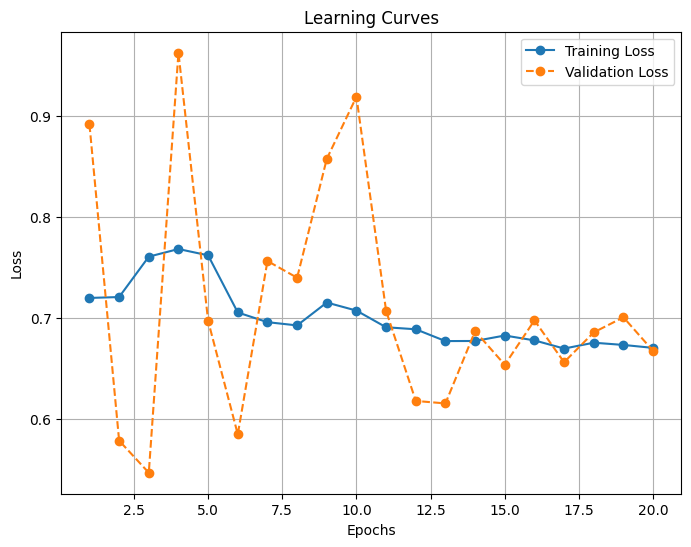

In [43]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    """
    Plots the learning curves of training and validation loss.

    Args:
        train_losses (list): List of training loss values per epoch.
        val_losses (list): List of validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


train_losses = training_results["loss"]
val_losses = validation_results["loss"]
plot_learning_curves(train_losses, val_losses)